# Modeling with Lemmatized Words
In this notebook I plan to run the same models as the previous notebook, with the exception of lemmatizing the words prior to vectorizing and modeling. This will take the words to a more uniform base and therefore have less words for the models to place. without lemmatizing I may have words like dance, dancing, danced, dances, after lemmatizing all these words would fall under dance.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from nltk.stem import WordNetLemmatizer 

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline Score

In [4]:
df["skip"].value_counts(normalize=True)

0    0.75993
1    0.24007
Name: skip, dtype: float64

### Pre-Processing

There are some words that I don't want displayed on screen so I will replace them as 'vulgar', they can still help my model with it's predictions. These words are not so much easy predictors, as much as they are words that I don't feel comfortable being part of my visualizations or my publicly viewable project.

In [5]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

To lemmatize my words, I first have to iterate through each value in the row if the lyrics column, then I have to split the values into separate words and lemmatize them. In the process the string in the column because a list of the words, I then need to reiterate through the values in the column and rejoin the list to be one string, so that they can be split apart correctly in the vectorizer in the pipeline

In [8]:
lemmatizer = WordNetLemmatizer() #instantiate model
df['lyrics'] = df['lyrics'].map(lambda x: [lemmatizer.lemmatize(word) for word in x.split()]) # for each row in the lyrics column, split the words and lemmatize
df['lyrics'] =  df['lyrics'].map(lambda x: ' '.join(x)) # for each row in the lyrics column rejoin the individual words

### Train Test Split
Same as the last set of models, X will be the lyrics and y (target) is the Skip classes


In [10]:
X = df['lyrics']
y = df['skip']

In [11]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

### Pipeline Fucntion

In [12]:
def start_pipeline(vect, model, color, pipe_params):
    
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
        
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
    elif model == 'lg':
        instantiate_model = LogisticRegression
        model_name = 'LogisticRegression'
    elif model == 'ada':
        instantiate_model = AdaBoostClassifier
        model_name = 'AdaBoostClassifier'     
    elif model == 'rdf':
        instantiate_model = RandomForestClassifier
        model_name = 'RandomForestClassifier'

        
        
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = 'english')), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train)
    preds = gs.predict(X_test)
    train_preds = gs.predict(X_train)
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}')
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}')
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%')
    print(f'{model_name} with {vect_name}  Test Score  :  {gs.score(X_test, y_test)*100:.2f}%')
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score is {f1_score(y_train, train_preds)}')
    print(f'{model_name} with {vect_name}  F1- Test Score is F1-Score is {f1_score(y_test, preds)}')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + fp))*100:.2f}%")
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);

In my note review of each upcomming model, I will make comparison notes to the first notebook, since the only thing that has changed between these two is the lemmatized words

### Multinomial Naive Bayes with Count Vectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.3min finished


Gridsearch best score is: 0.7891974988842769

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5500, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

MultinomialNB with CountVectorizer Train Score :  81.91%
MultinomialNB with CountVectorizer  Test Score  :  79.05%

MultinomialNB with CountVectorizer  F1- Train Score is 0.6537433155080214
MultinomialNB with CountVectorizer  F1- Test Score is F1-Score is 0.6036988110964332

55.33% of the words were predicted correctly by the model.
The specificity is: 83.04%


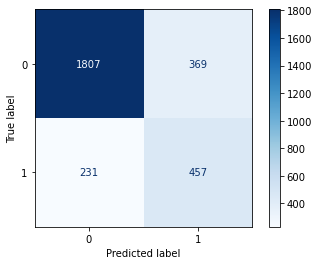

In [13]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Slight Increase in overall scores however still overfit

### Multinomial Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.3min finished


Gridsearch best score is: 0.8058442890897529

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  82.24%
MultinomialNB with TfidfVectorizer  Test Score  :  80.55%

MultinomialNB with TfidfVectorizer  F1- Train Score is 0.5971488912354804
MultinomialNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.5547561950439649

61.63% of the words were predicted correctly by the model.
The specificity is: 90.07%


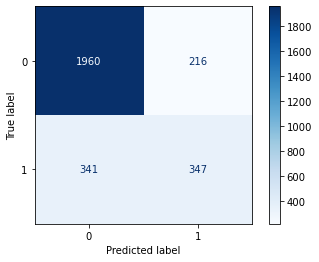

In [14]:

start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Again slightly better, scores have gotten closer to eachother compared to countvectorizer model and first notebook model, but still overfit

### Bernoulli Naive Bayes with Count Vectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.3min finished


Gridsearch best score is: 0.7945530369675089

Gridsearch best params are: {'Bnb__alpha': 0.425, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 3)}

BernoulliNB with CountVectorizer Train Score :  80.19%
BernoulliNB with CountVectorizer  Test Score  :  79.68%

BernoulliNB with CountVectorizer  F1- Train Score is 0.6529363784665579
BernoulliNB with CountVectorizer  F1- Test Score is F1-Score is 0.6442542787286064

55.59% of the words were predicted correctly by the model.
The specificity is: 80.65%


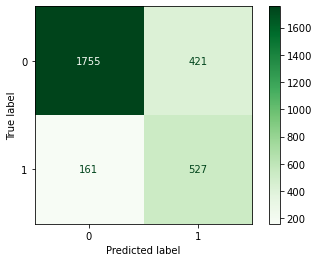

In [15]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Slight drop from first notebook

### Bernoulli Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.4min finished


Gridsearch best score is: 0.7939711002349282

Gridsearch best params are: {'Bnb__alpha': 0.5, 'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

BernoulliNB with TfidfVectorizer Train Score :  80.03%
BernoulliNB with TfidfVectorizer  Test Score  :  79.99%

BernoulliNB with TfidfVectorizer  F1- Train Score is 0.6499388004895961
BernoulliNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.6486817903126916

56.10% of the words were predicted correctly by the model.
The specificity is: 80.97%


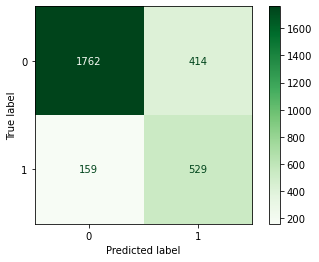

In [16]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})

Better than countvectorizer, but still slightly less than the previous notebook. I do like the closeness is scores though

### Logistic Regressions with Count Vectorizer

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.2min finished


Gridsearch best score is: 0.8102651933028178

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 1), 'lg__C': 0.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2'}

LogisticRegression with CountVectorizer Train Score :  99.69%
LogisticRegression with CountVectorizer  Test Score  :  81.46%

LogisticRegression with CountVectorizer  F1- Train Score is 0.9934098120576033
LogisticRegression with CountVectorizer  F1- Test Score is F1-Score is 0.6034353995519045

62.06% of the words were predicted correctly by the model.
The specificity is: 88.65%


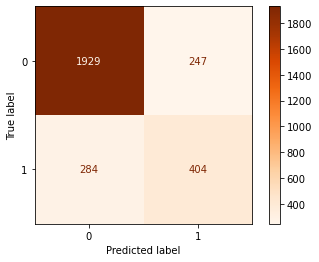

In [17]:
start_pipeline('cv', 'lg', 'Oranges', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                         'cv__min_df' : [2,3],
                                         'cv__max_df' : [.5, .95],
                                         'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                         'lg__penalty' : ['l1', 'l2'],
                                         'lg__C' : [0.5,1.0,2.5],
                                         'lg__max_iter' : [5000]})


It is safe to safe Logistic Regression just isnt the model this time around

### Logistic Regressions with TFIDF Vectorizer

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  9.7min finished


Gridsearch best score is: 0.8207429665432091

Gridsearch best params are: {'lg__C': 2.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2', 'tvec__max_df': 0.95, 'tvec__max_features': 9000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}

LogisticRegression with TfidfVectorizer Train Score :  90.40%
LogisticRegression with TfidfVectorizer  Test Score  :  82.09%

LogisticRegression with TfidfVectorizer  F1- Train Score is 0.7679324894514769
LogisticRegression with TfidfVectorizer  F1- Test Score is F1-Score is 0.5535248041775457

68.98% of the words were predicted correctly by the model.
The specificity is: 93.43%


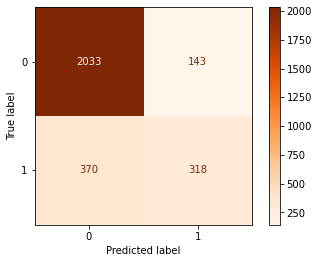

In [18]:
start_pipeline('tvec', 'lg', 'Oranges', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                            'tvec__min_df' : [2,3],
                                            'tvec__max_df' : [.5, .95],
                                            'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'lg__penalty' : ['l1', 'l2'],
                                            'lg__C' : [0.5,1.0,2.5],
                                            'lg__max_iter' : [5000]})

But if I had to pick a winner between these two, it would be this one

### Ada Boost with Count Vectorizer

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Gridsearch best score is: 0.8769649083955869

Gridsearch best params are: {'cv__max_df': 0.95, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 2)}

AdaBoostClassifier with CountVectorizer Train Score :  88.19%
AdaBoostClassifier with CountVectorizer  Test Score  :  87.47%

AdaBoostClassifier with CountVectorizer  F1- Train Score is 0.7215363511659807
AdaBoostClassifier with CountVectorizer  F1- Test Score is F1-Score is 0.705012325390304

81.10% of the words were predicted correctly by the model.
The specificity is: 95.40%


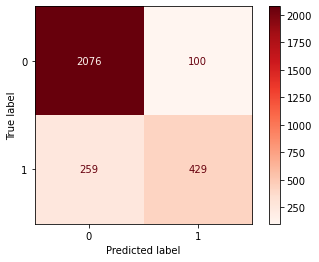

In [19]:
start_pipeline('cv', 'ada', 'Reds', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Again, great closeness, minimal misclassification, however slightly lower than the first notebook. We've lost about 3% on precision

### Ada Boost with TFIDF Vectorizer

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.0min finished


Gridsearch best score is: 0.8711445252370107

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 9000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}

AdaBoostClassifier with TfidfVectorizer Train Score :  88.35%
AdaBoostClassifier with TfidfVectorizer  Test Score  :  87.64%

AdaBoostClassifier with TfidfVectorizer  F1- Train Score is 0.7261285909712722
AdaBoostClassifier with TfidfVectorizer  F1- Test Score is F1-Score is 0.7084019769357496

81.75% of the words were predicted correctly by the model.
The specificity is: 95.59%


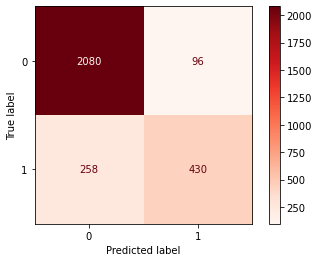

In [20]:
start_pipeline('tvec', 'ada', 'Reds', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)]})

Similar, better all around but lower than not lemmatizing

### Random Forest with Count Vectorizer

In [ ]:
start_pipeline('cv', 'rdf', 'Purples', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'rdf__min_samples_split': [14, 15, 16],
                                            'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 58.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 70.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 85.0min


### Random Forest with TFIDF Vectorizer

In [ ]:
start_pipeline('tvec', 'rdf', 'Purples', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                           'rdf__min_samples_split': [14, 15, 16],
                                           'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})